In [1]:
import cv2
import ipympl
import numpy as np
np.random.seed(42)
import pandas as pd
import math
import scipy.io
import hdf5storage
#import matplotlib
#matplotlib.use('nbagg')
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.stats.mstats import gmean 
from sklearn.model_selection import train_test_split
from keras.callbacks.callbacks import EarlyStopping
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.python.keras.models import Model
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from keras import backend as K
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from sklearn.metrics import classification_report
from keras.callbacks import TensorBoard
#indicate folder to save, plus other options
tensorboard = TensorBoard(log_dir='./logs/run', histogram_freq=1,
    write_graph=True, write_images=False)  

Using TensorFlow backend.


In [2]:
tf.compat.v1.disable_eager_execution()

In [3]:
file_name = "cardio.mat"
#file_name = "ionosphere.mat"
#file_name = "satellite.mat"
#file_name = "shuttle.mat"
#file_name = "smtp.mat"
#file_name = "wine.mat"
#file_name = "arrhythmia.mat"
#file_name = "thyroid.mat"

noise_amount = 2
sparsity = 1 
kernel_reg = 0.01
bias_reg = 0.01
iterations = 3
dropout = 0.1
firstLayerSize = 40
secondLayerSize = 25
midLayerSize = 15

In [4]:
#mat = scipy.io.loadmat('cardio.mat')
#mat = scipy.io.loadmat('shuttle.mat')
#
#mat = hdf5storage.loadmat('smtp.mat')
#mat = scipy.io.loadmat('wine.mat')
#mat = scipy.io.loadmat('arrhythmia.mat')
#mat = scipy.io.loadmat('thyroid.mat')

mat = scipy.io.loadmat(file_name)
#mat = scipy.io.loadmat('satellite.mat')

In [5]:
epochs = 200
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=1)]
#callbacks = [EarlyStopping(monitor='val_loss', patience=1),tensorboard]

In [6]:
Xtemp = mat['X']
ytemp = mat['y']
X = np.array(Xtemp)
y = np.array(ytemp)
print(X.shape)
y = y.reshape(X.shape[0],)
print(y.shape)

(3772, 6)
(3772,)


In [7]:
outliers = 0
clean_data = []
contam_data = []

for i in range(y.shape[0]):
    if(y[i]==1.0):
        outliers+=1;
        contam_data.append(X[i])
    else:
        clean_data.append(X[i])
      
print("Total number of outliers in Dataset")        
print(outliers)
contam = outliers/y.shape[0]
print("Contamination in Dataset")
print(contam)
clean_data = np.array(clean_data)
contam_data = np.array(contam_data)
print(clean_data.shape)
clean_data2 = clean_data.copy()
contam_data2 = contam_data.copy()
# test_data_full = []
# for i in range(176):
#     test_data_full.append(contam_data[i])
# one = np.ones(176)
# test_data_full = np.array(test_data_full)

# test_data_full= np.append(test_data_full,one,1)

# print(test_data_full.shape)

Xy = X.copy()
Xy.shape
Xy = np.array(Xy)
Xy = np.insert(Xy, X.shape[1], y, axis=1)
#print(Xy.shape)
count = outliers
count2 = outliers


    
#selecting all the outliers from dataset
test_data =[]
for i in range(Xy.shape[0]):
    if(Xy[i,X.shape[1]]==1 and count>0):
        test_data.append(Xy[i])
        count = count-1
    
test_data = np.array(test_data)

#selecting random inliers from train data and removing them
indexes = np.random.choice(clean_data.shape[0], outliers, replace=False)

random_clean_data = clean_data[indexes, :]
random_clean_data = np.hstack((random_clean_data, np.zeros((random_clean_data.shape[0], 1), dtype=random_clean_data.dtype)))

indexes = indexes.reshape(outliers,1)

#deleting the values from train data
clean_data = np.delete(clean_data,indexes,0)
#print(clean_data)                
test_data = np.append(test_data,random_clean_data,axis=0)
np.random.shuffle(test_data)

print("test_data.shape")
print(test_data.shape)
#print(test_data.shape)
test_x = test_data[:,:test_data.shape[1]-1]
test_y = test_data[:,test_data.shape[1]-1]
#print(test_x.shape)
#print(test_y.shape)
test_x = pd.DataFrame(test_x)
test_y = pd.DataFrame(test_y)

print("train_data.shape")                    
print(clean_data.shape)                         

Total number of outliers in Dataset
93
Contamination in Dataset
0.024655355249204668
(3679, 6)
test_data.shape
(186, 7)
train_data.shape
(3586, 6)


In [8]:
X_train, X_test = train_test_split(clean_data2,  test_size=0.03, random_state=42)
X_test = np.append(X_test,np.zeros((X_test.shape[0],1),dtype='float64'),axis=1)

inliers_test = X_test.shape[0]

contam_new = contam_data2.shape[0]/X_test.shape[0]
contam_data3 = np.append(contam_data2,np.ones((contam_data2.shape[0],1),dtype='float64'),axis=1)
outliers_test = contam_data3.shape[0]
X_test = np.append(X_test,contam_data3,axis=0)
np.random.shuffle(X_test)
Xy_test = X_test.copy
y_test = X_test[:,X_test.shape[1]-1]
#print(y_test.shape)
X_test = np.delete(X_test,X_test.shape[1]-1,axis=1)
#print(X_test.shape)

X_test_np = X_test
y_test_np = y_test
print(y_test.shape)

X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)
print("Number of Outliers in Test")
print(outliers_test)
print("Number of Inliers in Test")
print(inliers_test)
#print(X_train)
#print(X_train.mean())
#print(pd.DataFrame(X_train).describe())
X_train_noisy = X_train
#noisy data
#print(X_train_noisy)
def apply_noise(col):
    #print(col.mean())
    mu, sigma = 0, abs(col.mean())
    noise = np.random.normal(mu, sigma, col.shape[0]) 
    for i  in range(col.shape[0]):
        col[i] += noise[i]

    return col
#print(X_train)
X_train_noisy = np.apply_along_axis(apply_noise, 0, X_train)

(204,)
Number of Outliers in Test
93
Number of Inliers in Test
111


In [9]:
scaler = MinMaxScaler(feature_range=(-1, 1))
clean_data = scaler.fit_transform(clean_data)
test_x  = scaler.transform(test_x)
clean_data = pd.DataFrame(clean_data)

scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)
clean_data = pd.DataFrame(clean_data)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
                  0
Model 2    0.994188
Ensemble   0.788337
Ensemble2  0.963770
Model _de  0.081469
Model _s   0.986341
Model _s3  0.971617
Model c    0.994188


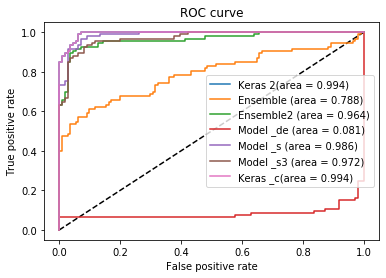

0
                  0
Model 2    0.990119
Ensemble   0.967451
Ensemble2  0.964158
Model _de  0.666279
Model _s   0.986341
Model _s3  0.969195
Model c    0.990119


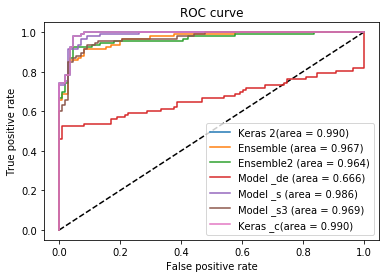

1
                  0
Model 2    0.975298
Ensemble   0.967354
Ensemble2  0.960864
Model _de  0.367044
Model _s   0.986341
Model _s3  0.974523
Model c    0.975298


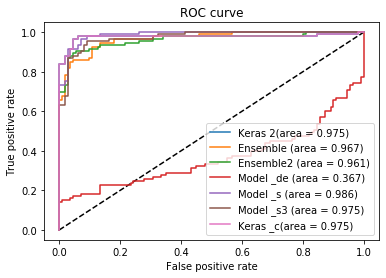

2


In [10]:
for k in range(iterations): 
    #deep autoencoder
    inputs = Input(shape=(X.shape[1],))

    #deep autoencoder
    encoded2 = Dense(firstLayerSize, activation='relu'
                     #,activity_regularizer=regularizers.l1(1e-3)
                    #, kernel_regularizer=l2(kernel_reg) 
                   #, bias_regularizer=l2(bias_reg)
                    )(inputs)
    encoded2 = Dense(secondLayerSize, activation='relu'
                     #,activity_regularizer=regularizers.l1(1e-3)
                     #,kernel_regularizer=l2(kernel_reg)
                    #,bias_regularizer=l2(bias_reg)
                    )(encoded2)
    #encoded2 = Dense(round(X.shape[1]/6), activation='relu')(encoded2)
    encoded2 = Dense(midLayerSize, activation='relu'
                    #,activity_regularizer=regularizers.l1(1e-3)
                     #,kernel_regularizer=l2(kernel_reg)
                    # ,bias_regularizer=l2(bias_reg)
                    )(encoded2)

    #decoded2 = Dense(round(X.shape[1]/6), activation='relu')(encoded2)
    decoded2 = Dense(secondLayerSize, activation='relu'
                   
                     #,kernel_regularizer=l2(kernel_reg)
                    # ,bias_regularizer=l2(bias_reg)
                    )(encoded2)
    decoded2 = Dense(firstLayerSize, activation='relu'
                   
                    #,kernel_regularizer=l2(kernel_reg)
                    #,bias_regularizer=l2(bias_reg)
                    )(decoded2)
    decoded2 = Dense(X.shape[1], activation='tanh')(decoded2)

    autoencoder2 = Model(inputs, decoded2)
    for num, layer in enumerate(autoencoder2.layers):
        layer._name = 'autoencoder2_' + str(num)+'_'+str(k)
    #autoencoder2.summary()
    autoencoder2.compile(optimizer='adam', loss='mse')

    autoencoder2.fit(X_train, X_train,
                    epochs=epochs,
                    batch_size=256,
                    shuffle=False,
                    callbacks=callbacks,
                    validation_split=0.4,
                    verbose=0
                   )

    #encoded_data = encoder.predict(test_x)
    decoded_data2 = autoencoder2.predict(X_test)

    #print(dict(zip(unique, counts)))
    mse2 = np.mean(np.power(X_test - decoded_data2, 2), axis=1)
    mse2 = mse2.reshape(-1, 1)
    #print(mse2.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    mse2 = scaler.fit_transform(mse2)

    y_pred_bool2 = np.argmax(decoded_data2, axis=1)
    #print(classification_report(y_test, y_pred_bool2))

    df_error2 = pd.DataFrame({'reconstruction_error': mse2[:,0]})
    #df_error2.describe()
    
     #deep autoencoder
    encoded2_c = Dense(firstLayerSize, activation='relu'
                     #,activity_regularizer=regularizers.l1(1e-3)
                    , kernel_regularizer=l2(kernel_reg) 
                    , bias_regularizer=l2(bias_reg)
                    )(inputs)
    encoded2_c = Dense(secondLayerSize, activation='relu'
                     #,activity_regularizer=regularizers.l1(1e-3)
                    ,kernel_regularizer=l2(kernel_reg)
                    ,bias_regularizer=l2(bias_reg)
                    )(encoded2_c)
    #encoded2 = Dense(round(X.shape[1]/6), activation='relu')(encoded2)
    encoded2_c = Dense(midLayerSize, activation='relu'
                    #,activity_regularizer=regularizers.l1(1e-3)
                     ,kernel_regularizer=l2(kernel_reg)
                     ,bias_regularizer=l2(bias_reg)
                    )(encoded2_c)

    #decoded2 = Dense(round(X.shape[1]/6), activation='relu')(encoded2)
    decoded2_c = Dense(secondLayerSize, activation='relu'
                   
                     ,kernel_regularizer=l2(kernel_reg)
                     ,bias_regularizer=l2(bias_reg)
                    )(encoded2_c)
    decoded2_c = Dense(firstLayerSize, activation='relu'
                   
                    ,kernel_regularizer=l2(kernel_reg)
                    ,bias_regularizer=l2(bias_reg)
                    )(decoded2_c)
    decoded2_c = Dense(X.shape[1], activation='tanh')(decoded2_c)

    autoencoder2_c = Model(inputs, decoded2)
    for num, layer in enumerate(autoencoder2_c.layers):
        layer._name = 'autoencoder2_c_' + str(num)+'_'+str(k)
    #autoencoder2.summary()
    autoencoder2_c.compile(optimizer='adam', loss='mse')

    autoencoder2_c.fit(X_train, X_train,
                    epochs=epochs,
                    batch_size=256,
                    shuffle=False,
                    callbacks=callbacks,
                    validation_split=0.4,
                    verbose=0
                   )

    #encoded_data = encoder.predict(test_x)
    decoded_data2_c = autoencoder2_c.predict(X_test)

    #print(dict(zip(unique, counts)))
    mse2_c = np.mean(np.power(X_test - decoded_data2_c, 2), axis=1)
    mse2_c = mse2_c.reshape(-1, 1)
    #print(mse2.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    mse2_c = scaler.fit_transform(mse2)


    #denoising autoencoder
    encoded2_de = Dense(firstLayerSize, activation='relu'
                     #,activity_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)
                    #, kernel_regularizer=l2(kernel_reg) 
                    #, bias_regularizer=l2(bias_reg)
                    )(inputs)
    encoded2_de = Dense(secondLayerSize, activation='relu'
                     #,activity_regularizer=regularizers.l1(1e-3)
                    #,kernel_regularizer=l2(kernel_reg)
                   #,bias_regularizer=l2(bias_reg)
                    )(encoded2_de)
    #encoded2 = Dense(round(X.shape[1]/6), activation='relu')(encoded2)
    encoded2_de = Dense(midLayerSize, activation='relu'
                    #,activity_regularizer=regularizers.l1(1e-3)
                    )(encoded2_de)

    #decoded2 = Dense(round(X.shape[1]/6), activation='relu')(encoded2)
    decoded2_de = Dense(secondLayerSize, activation='relu'
                   #  ,
                    # kernel_regularizer=l2(kernel_reg), 
                   # bias_regularizer=l2(bias_reg)
                    )(encoded2_de)
    decoded2_de = Dense(firstLayerSize, activation='relu'
                   #  ,
                   #  kernel_regularizer=l2(kernel_reg), 
                   # bias_regularizer=l2(bias_reg)
                    )(decoded2_de)
    decoded2_de = Dense(X.shape[1], activation='tanh')(decoded2_de)




    autoencoder2_de = Model(inputs, decoded2_de)
    for num, layer in enumerate(autoencoder2_de.layers):
        layer._name = 'autoencoder2_de_' + str(num)+'_'+str(k)
    #autoencoder2_de.summary()
    autoencoder2_de.compile(optimizer='adam', loss='mse')

    autoencoder2_de.fit(X_train_noisy, X_train,
                    epochs=epochs,
                    batch_size=256,
                    shuffle=False,
                    callbacks=callbacks,
                    validation_split=0.4,
                    verbose=0
    )

    #encoded_data = encoder.predict(test_x)
    decoded_data_de = autoencoder2_de.predict(X_test)

    #print(dict(zip(unique, counts)))
    mse_de = np.mean(np.power(X_test - decoded_data_de, 2), axis=1)
    mse_de = mse_de.reshape(-1, 1)
    #print(mse_de.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    mse_de = scaler.fit_transform(mse_de)
    df_error_de = pd.DataFrame({'reconstruction_error': mse_de[:,0]})
    #df_error_de.describe()






    #sparse autoencoder
    encoded2_s = Dense(firstLayerSize, activation='relu'
                    #,activity_regularizer=regularizers.l1(sparsity)
                   # , kernel_regularizer=l2(kernel_reg) 
                   # , bias_regularizer=l2(bias_reg)
                    )(inputs)
    encoded2_s = Dense(secondLayerSize, activation='relu'
                   # ,activity_regularizer=regularizers.l1(sparsity)
                   # ,kernel_regularizer=l2(kernel_reg)
                   # ,bias_regularizer=l2(bias_reg)
                    )(encoded2_s)
    #encoded2 = Dense(round(X.shape[1]/6), activation='relu')(encoded2)
    encoded2_s = Dense(midLayerSize, activation='relu'
                    ,activity_regularizer=regularizers.l1(sparsity)
                    )(encoded2_s)

    #decoded2 = Dense(round(X.shape[1]/6), activation='relu')(encoded2)
    decoded2_s = Dense(secondLayerSize, activation='relu'
                   # ,activity_regularizer=regularizers.l1(sparsity)
                    # kernel_regularizer=l2(kernel_reg), 
                   # bias_regularizer=l2(bias_reg)
                    )(encoded2_s)
    decoded2_s = Dense(firstLayerSize, activation='relu'
                   # ,activity_regularizer=regularizers.l1(sparsity)
                   #  kernel_regularizer=l2(kernel_reg), 
                   # bias_regularizer=l2(bias_reg)
                    )(decoded2_s)
    decoded2_s = Dense(X.shape[1], activation='tanh')(decoded2_s)




    autoencoder2_s = Model(inputs, decoded2_s)
    for num, layer in enumerate(autoencoder2_s.layers):
        layer._name = 'autoencoder2_s_' + str(num)+'_'+str(k)
    #autoencoder2_s.summary()
    autoencoder2_s.compile(optimizer='adam', loss='mse')

    autoencoder2_s.fit(X_train, X_train,
                    epochs=epochs,
                    batch_size=256,
                    shuffle=False,
                    callbacks=callbacks,
                    validation_split=0.4,
                    verbose=0
    )
    
    
    
    #encoded_data = encoder.predict(test_x)
    decoded_data_s = autoencoder2_s.predict(X_test)

    #print(dict(zip(unique, counts)))
    mse_s = np.mean(np.power(X_test - decoded_data_s, 2), axis=1)
    mse_s = mse_s.reshape(-1, 1)
    #print(mse_s.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    mse_s = scaler.fit_transform(mse_s)
    df_error_s = pd.DataFrame({'reconstruction_error': mse_s[:,0]})
    #df_error_s.describe()
 
     
    #sparse autoencoder new
    encoded3_s3 = Dense(firstLayerSize, activation='relu'
                    #,activity_regularizer=regularizers.l1(sparsity)
                   # ,kernel_regularizer=l2(kernel_reg)
                   # ,bias_regularizer=l2(bias_reg)
                     )(inputs)
    encoded3_s3 = Dropout(dropout)(encoded3_s3)
    encoded3_s3 = Dense(secondLayerSize, activation='relu'
                    #,activity_regularizer=regularizers.l1(sparsity)
                   # ,kernel_regularizer=l2(kernel_reg) 
                   # ,bias_regularizer=l2(bias_reg)
                    )(encoded3_s3)
    encoded3_s3 = Dropout(dropout)(encoded3_s3)
    encoded3_s3 = Dense(midLayerSize, activation='relu'
                      ,activity_regularizer=regularizers.l1(sparsity)
    #                  kernel_regularizer=l2(kernel_reg), 
    #                 bias_regularizer=l2(bias_reg)
                    )(encoded3_s3)
    encoded3_s3 = Dropout(dropout)(encoded3_s3)

    #decoded2 = Dense(80, activation='relu')(encoded2)
    decoded3_s3 = Dense(secondLayerSize, activation='relu'
                   #,activity_regularizer=regularizers.l1(sparsity)
                   # , kernel_regularizer=l2(kernel_reg), 
                   # bias_regularizer=l2(bias_reg)
                    )(encoded3_s3)
    decoded3_s3 = Dropout(dropout)(decoded3_s3)
    decoded3_s3 = Dense(firstLayerSize, activation='relu'
                    #,activity_regularizer=regularizers.l1(sparsity)
                   # , kernel_regularizer=l2(kernel_reg), 
                   # bias_regularizer=l2(bias_reg)
                    )(decoded3_s3)
    decoded3_s3 = Dropout(dropout)(decoded3_s3)
    decoded3_s3 = Dense(X.shape[1], activation='tanh')(decoded3_s3)
    decoded3_s3 = Dropout(dropout)(decoded3_s3)

    autoencoder3_s3 = Model(inputs, decoded3_s3)
    
    for num, layer in enumerate(autoencoder3_s3.layers):
        layer._name = 'autoencoder3_s3_' + str(num)+'_'+str(k)
        
    autoencoder3_s3.compile(optimizer='adam', loss='mse')
    #autoencoder3_s3.summary()

    autoencoder3_s3.fit(X_train, X_train,
                    epochs=epochs,
                    batch_size=256,
                    shuffle=True,
                    callbacks=callbacks,
                    validation_split=0.4,
                    verbose=0
    )

    decoded_data3_s3 = autoencoder3_s3.predict(X_test)
    mse3_s3 = np.mean(np.power(X_test - decoded_data3_s3, 2), axis=1)
    
    ensemble = [];
    for i in range(0,mse2.size):
        ensemble.append(0.2*mse_de[i]+0.2*mse2[i][0]+0.2*mse2_c[i][0]+0.2*mse_s[i] +0.2*mse3_s3[i])
    #print(ensemble)

    from tensorflow.keras.layers import concatenate
    from tensorflow.keras.layers import Flatten
    from tensorflow.keras.models import Model
    x = concatenate([decoded3_s3, decoded2, decoded2_c, decoded2_de, decoded2_s])  # merge the outputs of the two models
    out = Flatten()(x)
    out = Dense(10,activation='relu'
                ,activity_regularizer=regularizers.l2(0.001)
                 , kernel_regularizer=regularizers.l2(0.01)
                 ,bias_regularizer=regularizers.l2(0.01)
               )(out)
    out = Dense(X.shape[1],activation='tanh'
                ,activity_regularizer=regularizers.l2(0.001)
                 , kernel_regularizer=regularizers.l2(0.01)
                 ,bias_regularizer=regularizers.l2(0.01)
               )(out)  # final layer of the network
    model = Model(inputs=inputs, outputs=out)
    for l in model.layers:
        l.trainable = False

    model.layers[len(model.layers)-1].trainable = True
    model.layers[len(model.layers)-2].trainable = True
    model.layers[len(model.layers)-3].trainable = True
    #model.summary()

    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, X_train,
                    epochs=500,
                    batch_size=256,
                    shuffle=True,
                    callbacks=callbacks,
                    validation_split=0.4,
                    verbose=0
    )

    ensemble_pred = model.predict(X_test)
    #print(ensemble_pred)
    ensemble2_mse = np.mean(np.power(X_test - ensemble_pred, 2), axis=1)
    

    from sklearn.metrics import roc_curve
    from sklearn.metrics import auc

    
    fpr_keras2, tpr_keras2, thresholds_keras2 = roc_curve(y_test, mse2)
    fpr_keras5, tpr_keras5, thresholds_keras5 = roc_curve(y_test, ensemble2_mse)
    fpr_keras_de, tpr_keras_de, thresholds_keras_de = roc_curve(y_test, mse_de)
    fpr_keras_s, tpr_keras_s, thresholds_keras_s = roc_curve(y_test, mse_s)
    fpr_keras_s3, tpr_keras_s3, thresholds_keras_s3 = roc_curve(y_test, mse3_s3)
    fpr_kerasE, tpr_kerasE, thresholds_kerasE = roc_curve(y_test, ensemble)
    fpr_keras2_c, tpr_keras2_c, thresholds_keras2_c = roc_curve(y_test, mse2_c)          

    #print(thresholds_keras2)
    
    auc_keras2 = auc(fpr_keras2, tpr_keras2)
    auc_kerasE = auc(fpr_kerasE, tpr_kerasE)
    auc_keras5 = auc(fpr_keras5, tpr_keras5)
    auc_keras_de = auc(fpr_keras_de, tpr_keras_de)
    auc_keras_s = auc(fpr_keras_s, tpr_keras_s)
    auc_keras_s3 = auc(fpr_keras_s3, tpr_keras_s3)
    auc_keras2_c = auc(fpr_keras2_c, tpr_keras2_c)
    a = pd.DataFrame([ auc_keras2, auc_kerasE, auc_keras5, auc_keras_de, auc_keras_s, auc_keras_s3, auc_keras2_c], [ "Model 2", "Ensemble", "Ensemble2", "Model _de", "Model _s", "Model _s3", "Model c"])
    print(a)
    
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras2, tpr_keras2, label='Keras 2(area = {:.3f})'.format(auc_keras2))
    plt.plot(fpr_kerasE, tpr_kerasE, label='Ensemble (area = {:.3f})'.format(auc_kerasE))
    plt.plot(fpr_keras5, tpr_keras5, label='Ensemble2 (area = {:.3f})'.format(auc_keras5))
    plt.plot(fpr_keras_de, tpr_keras_de, label='Model _de (area = {:.3f})'.format(auc_keras_de))
    plt.plot(fpr_keras_s, tpr_keras_s, label='Model _s (area = {:.3f})'.format(auc_keras_s))
    plt.plot(fpr_keras_s3, tpr_keras_s3, label='Model _s3 (area = {:.3f})'.format(auc_keras_s3))
    plt.plot(fpr_keras2_c, tpr_keras2_c, label='Keras _c(area = {:.3f})'.format(auc_keras2_c))
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    
    if(k==0):
        sums = [auc_keras2, auc_kerasE, auc_keras5, auc_keras_de, auc_keras_s, auc_keras_s3, auc_keras2_c];
    else:
        temp = [auc_keras2, auc_kerasE, auc_keras5, auc_keras_de, auc_keras_s, auc_keras_s3, auc_keras2_c]
        for tempi in range(0,len(sums)):
            sums[tempi] = sums[tempi]+temp[tempi];

    import csv
    from datetime import date
    with open('resultsAllModels2.csv', 'a', newline='') as file:
        writer = csv.writer(file)
        if(k==iterations-1):
            today = date.today()
            d1 = today.strftime("%d/%m/%Y")
            writer.writerow([d1])
            writer.writerow([file_name])
            writer.writerow(["params","noise_amount",noise_amount,"sparsity" ,sparsity,"kernel_reg", kernel_reg,"bias_reg" ,bias_reg,"iterations" ,iterations])
            writer.writerow(["Model 2", "Ensemble", "Ensemble2", "Model _de", "Model _s", "Model _s3","Model c"])
            writer.writerow([x/iterations for x in sums])
    print(k)
    

In [11]:
"
# outputs = [layer.output for layer in autoencoder2_s.layers]
# #print(outputs[0].eval())
# # Initialize session 
# # or, for passing in a layer directly
# def get_all_outputs(model, input_data, learning_phase=1):
#     outputs = [layer.output for layer in model.layers[1:]] # exclude Input
#     layers_fn = K.function([model.input, K.learning_phase()], outputs)
#     return layers_fn([input_data, learning_phase])

# #print(get_all_outputs(autoencoder2_s,X_test))
# for i in range(len(get_all_outputs(autoencoder2_s,X_test)[1])):
#     plt.plot(get_all_outputs(autoencoder2_s,X_test)[1][i])
    
# print((get_all_outputs(autoencoder2_s,X_test)[0][0]))
#plt.hist(get_all_outputs(autoencoder2_s,X_test)[0][0])
#plt.hist(get_all_outputs(autoencoder2_s,X_test)[0][1])
#plt.hist(get_all_outputs(autoencoder2_s,X_test)[0][2])

    

SyntaxError: EOL while scanning string literal (<ipython-input-11-9acc32cec59b>, line 1)

In [ ]:
clean_pd = pd.DataFrame(clean_data2)
clean_pd.describe()

In [ ]:
clean_pd = pd.DataFrame(clean_data2)
clean_pd.describe()

In [ ]:
clean_pd = pd.DataFrame(clean_data2)
clean_pd.describe()

In [ ]:
clean_pd = pd.DataFrame(clean_data2)
clean_pd.describe()

In [ ]:
# for i in range(len(get_all_outputs(autoencoder2,X_test)[1])):
#     plt.plot(get_all_outputs(autoencoder2,X_test)[1][i])

In [ ]:
import keract
from keract import get_gradients_of_trainable_weights

c = keract.get_gradients_of_activations(autoencoder3_de2, X_test, X_test)
for key, value in c.items():
    if('dense' in key):
        plt.plot(c[key])
#print(b)

In [ ]:
import keract
from keract import get_gradients_of_trainable_weights
from keract import get_gradients_of_activations


a = keract.get_gradients_of_activations(autoencoder3_s3, X_train, X_train)
#print(a)
for key, value in a.items():
    if('dense' in key):
        plt.plot(a[key])
    


In [ ]:


d = keract.get_gradients_of_activations(autoencoder3_s2, X_train, X_train)
#print(a)
for key, value in d.items():
    if('dense' in key):
        plt.plot(d[key])
    

In [ ]:

e = keract.get_gradients_of_activations(autoencoder2_s, X_train, X_train)
#print(a)
for key, value in e.items():
    if('dense' in key):
        plt.plot(e[key])
    

In [ ]:
w = keract.get_gradients_of_activations(autoencoder2, X_train, X_train)
#print(a)
for key, value in w.items():
    if('dense' in key):
        plt.plot(w[key])
    

#plt.hist(a['dense_704/bias:0'])

In [ ]:
import keract
from keract import get_gradients_of_trainable_weights

b = keract.get_gradients_of_activations(autoencoder3, X_train, X_train)
#print(a)
for key, value in b.items():
    if('dense' in key):
        plt.plot(b[key])
    

In [ ]:
plt.hist(a['dense_706/kernel:0'])
#plt.hist(a['dense_706/bias:0'])

In [ ]:
plt.hist(a['dense_707/kernel:0'])
#plt.hist(a['dense_707/bias:0'])

In [ ]:
plt.hist(a['dense_708/kernel:0'])
#plt.hist(a['dense_708/bias:0'])

In [ ]:
plt.hist(a['dense_709/kernel:0'])
#plt.hist(a['dense_709/bias:0'])

In [ ]:
plt.hist(a['dense_710/kernel:0'])
#plt.hist(a['dense_710/bias:0'])

In [ ]:
plt.hist(a['dense_711/kernel:0'])
#plt.hist(a['dense_711/bias:0'])

In [ ]:
print(a)

In [ ]:


for l in autoencoder3_s3.layers:
        for a in l.get_weights():
            plt.hist(a)
            
    

In [ ]:
for l in autoencoder3_s2.layers:
        for a in l.get_weights():
            plt.hist(a)

In [ ]:
for l in autoencoder3.layers:
        for a in l.get_weights():
            plt.hist(a)

In [ ]:
for l in autoencoder2_de.layers:
        for a in l.get_weights():
            plt.hist(a)

In [ ]:
import tensorflow
import tempfile
import tensorflow_model_optimization as tfmot

pruning_epochs = 100
# Load functionality for adding pruning wrappers
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute the pruning end step
num_images = X_train.shape[0] * (1 - 0.4)
end_step = np.ceil(num_images / 256).astype(np.int32) * pruning_epochs

# Define pruning configuration
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.00,
                                                               final_sparsity=0.9,
                                                               begin_step=0.2*end_step,
                                                               end_step=end_step)
}
model_for_pruning = prune_low_magnitude(autoencoder3, **pruning_params)
    


# Recompile the model
model_for_pruning.compile(optimizer='adam', loss='mse',
              metrics=['accuracy'])

# Model callbacks
log_dir = '.\logs'
callbacks2 = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir, profile_batch = 100000000, histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch'),
  tfmot.sparsity.keras.PruningSummaries(
    log_dir, update_freq='epoch'
  )
]

# Fitting data
model_for_pruning.fit(X_train, X_train,
                      batch_size=256,
                      epochs=pruning_epochs,
                      verbose=1,
                      callbacks=callbacks2,
                      validation_split=0.4)

In [ ]:
for l in model_for_pruning.layers:
        for a in l.get_weights():
            plt.hist(a)

In [ ]:
decoded_data3_p = model_for_pruning.predict(X_test)

mse3_p = np.mean(np.power(X_test - decoded_data3_p, 2), axis=1)
df_error3_p = pd.DataFrame({'reconstruction_error': mse3_p})
fpr_kerasp, tpr_kerasp, thresholds_kerasp = roc_curve(y_test, mse3_p)
auc_kerasp = auc(fpr_kerasp, tpr_kerasp)
print(auc_kerasp)

In [ ]:
i = np.arange(len(tpr_keras)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr_keras, index=i),'tpr' : pd.Series(tpr_keras, index = i), '1-fpr' : pd.Series(1-fpr_keras, index = i), 'tf' : pd.Series(tpr_keras - (1-fpr_keras), index = i), 'thresholds' : pd.Series(thresholds_keras, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]


# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])

roc = pd.DataFrame({'tf' : pd.Series(tpr_keras-(1-fpr_keras), index=i), 'threshold' : pd.Series(thresholds_keras, index=i)})
roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
#list(roc_t['threshold'])
threshold1 = roc_t['threshold']
print(threshold1)
threshold1 = threshold1.to_numpy()
threshold1 = threshold1[0]

In [ ]:
i = np.arange(len(tpr_keras2)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr_keras2, index=i),'tpr' : pd.Series(tpr_keras2, index = i), '1-fpr' : pd.Series(1-fpr_keras2, index = i), 'tf' : pd.Series(tpr_keras2 - (1-fpr_keras2), index = i), 'thresholds' : pd.Series(thresholds_keras2, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]


# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])

roc = pd.DataFrame({'tf' : pd.Series(tpr_keras2-(1-fpr_keras2), index=i), 'threshold' : pd.Series(thresholds_keras2, index=i)})
roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
list(roc_t['threshold'])
threshold2 = roc_t['threshold']
print(threshold2)
threshold2 = threshold2.to_numpy()
threshold2 = threshold2[0]

In [ ]:
i = np.arange(len(tpr_keras3)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr_keras3, index=i),'tpr' : pd.Series(tpr_keras3, index = i), '1-fpr' : pd.Series(1-fpr_keras3, index = i), 'tf' : pd.Series(tpr_keras3 - (1-fpr_keras3), index = i), 'thresholds' : pd.Series(thresholds_keras3, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]


# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])

roc = pd.DataFrame({'tf' : pd.Series(tpr_keras3-(1-fpr_keras3), index=i), 'threshold' : pd.Series(thresholds_keras3, index=i)})
roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
list(roc_t['threshold'])
threshold3 = roc_t['threshold']
print(threshold3)
threshold3 = threshold3.to_numpy()
threshold3 = threshold3[0]

In [ ]:
i = np.arange(len(tpr_keras4)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr_keras4, index=i),'tpr' : pd.Series(tpr_keras4, index = i), '1-fpr' : pd.Series(1-fpr_keras4, index = i), 'tf' : pd.Series(tpr_keras4 - (1-fpr_keras4), index = i), 'thresholds' : pd.Series(thresholds_keras4, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]


# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])

roc = pd.DataFrame({'tf' : pd.Series(tpr_keras4-(1-fpr_keras4), index=i), 'threshold' : pd.Series(thresholds_keras4, index=i)})
roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
#list(roc_t['threshold'])
threshold4 = roc_t['threshold']
print(threshold4)
threshold4 = threshold4.to_numpy()
threshold4 = threshold4[0]

In [ ]:
print(max(auc_keras3,auc_keras2,auc_keras))
print(min(auc_keras3,auc_keras2,auc_keras))
print(max(auc_keras3,auc_keras2,auc_keras)-min(auc_keras3,auc_keras2,auc_keras))
print((auc_keras3+auc_keras2+auc_keras)/3)

In [ ]:
#ensemble

result1 = [];
result2 = [];
result3 = [];
result4 = [];
#print(threshold1)
print('1') 
for i in range(0,mse.size):
    if(mse[i][0]>threshold1):
        result1.append(1);
    else:
        result1.append(0);
    if(mse2[i][0]>threshold2):
        result2.append(1);
    else:
        result2.append(0);
    if(mse3[i]>threshold3):
        result3.append(1);
    else:
        result3.append(0);
    if(mse4[i]>threshold4):
        result4.append(1);
    else:
        result4.append(0);
        
correct =0; 
correct2 =0; 
correct3 =0; 
correct4 =0; 
correctE =0;
for i in range(0,mse.size):
    if(result1[i] == y_test.to_numpy()[i]):
        correct = correct + 1;

print(correct/mse.size)
print('2') 

for i in range(0,mse.size):
    if(result2[i] == y_test.to_numpy()[i]):
        correct2 = correct2 + 1;
        

print(correct2/mse.size)
print('3') 

for i in range(0,mse.size):
    if(result3[i] == y_test.to_numpy()[i]):
        correct3 = correct3 + 1;
print(correct3/mse.size)
print('4')   

for i in range(0,mse.size):
    if(result4[i] == y_test.to_numpy()[i]):
        correct4 = correct4 + 1;

print(correct4/mse.size)
print('E')  


for i in range(0,mse.size):
    temp = (result1[i] + result2[i] + result3[i] + result4[i])/4
    if(temp>0.5):
        if(1 == y_test.to_numpy()[i]):
            correctE = correctE + 1;
    else:
        if(0 == y_test.to_numpy()[i]):
            correctE = correctE + 1;
        
print(correctE/mse.size)


In [ ]:
# from deepstack.base import KerasMember

# X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.4, random_state=23)

# member1 = KerasMember(name="model1", keras_model=autoencoder, train_batches=(X_train, X_train), val_batches=(X_test,X_test))
# member2 = KerasMember(name="model2", keras_model=autoencoder2, train_batches=(X_train, X_train), val_batches=(X_test,X_test))
# member3 = KerasMember(name="model3", keras_model=autoencoder3, train_batches=(X_train, X_train), val_batches=(X_test,X_test))
# member4 = KerasMember(name="model4", keras_model=autoencoder4, train_batches=(X_train, X_train), val_batches=(X_test,X_test))


In [ ]:
# from deepstack.ensemble import DirichletEnsemble

# wAvgEnsemble = DirichletEnsemble()
# wAvgEnsemble.add_members([member1, member2, member3, member4])
# wAvgEnsemble.fit()
# wAvgEnsemble.describe()

In [ ]:
# from keras.layers import Layer as layers
# from keras.layers import  Input, Dense 

# from keras.models import Model
# import keras.backend as K
# import tensorflow as tf

# class WeightedSum(layers):
#     """A custom keras layer to learn a weighted sum of tensors"""
#     constraint=tf.keras.constraints.min_max_norm(max_value=1,min_value=0)
#     def __init__(self, **kwargs):
#         super(WeightedSum, self).__init__(**kwargs)

#     def build(self, input_shape=1):
#         self.a = self.add_weight(
#             name='alpha',
#             shape=(),
#             initializer='ones',
#             dtype='float32',
#             trainable=True,
#         )
#         super(WeightedSum, self).build(input_shape)

#     def call(self, model_outputs):
#         return self.a * model_outputs[0] + (1 - self.a) * model_outputs[1]

#     def compute_output_shape(self, input_shape):
#         return input_shape[0]

In [ ]:
# # Weighed sum of the two models' outputs with a = 0.1
# out = WeightedSum([autoencoder.output, autoencoder2.output])

# # Create the merged model
# model = Model(inputs=[inputs, inputs2], outputs=[out])